In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import torch.backends
from torch.nn import Module, Linear, ReLU
from torch.optim import SGD
from torch.nn import MSELoss

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cudnn.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


# Generate Data

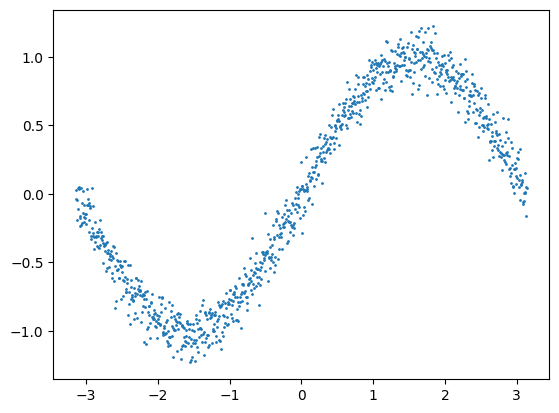

In [77]:
f = np.sin

x = np.linspace(- np.pi, np.pi, 1000)
eps = np.random.normal(0, 0.1, 1000)

y = f(x) + eps

plt.scatter(x, y, s=1)
plt.show()

x_train = x
y_train = y

In [78]:
# Create Data Set
x = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)

# Create Data Loader
batch_size = 10
data = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Train Model

In [79]:
class NNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNModel, self).__init__()
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out
    
fhat = NNModel(1, 1000000, 1).to(device)

# Initialize weights to be close to 0
for param in fhat.parameters():
    param.data.normal_(0, 0.01)

In [80]:
# Training Loop
optimizer = SGD(fhat.parameters(), lr=0.01)
regularization = 0.001
criterion = MSELoss()
epochs = 1000

for epoch in range(epochs):
    for x, y in loader:
        optimizer.zero_grad()
        yhat = fhat(x)
        loss = criterion(yhat, y) + regularization * (torch.sum(fhat.linear1.weight ** 2) + torch.sum(fhat.linear2.weight ** 2))
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, loss.item()))
        

Epoch: 0, Loss: nan


KeyboardInterrupt: 

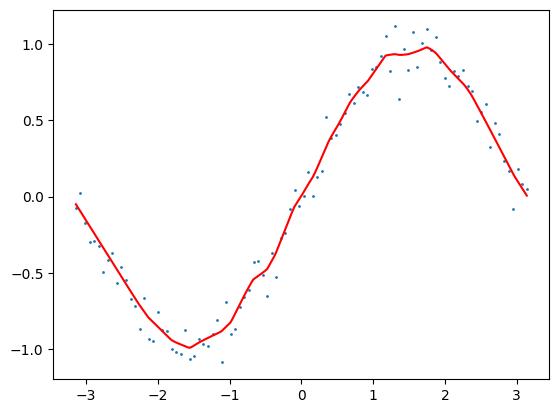

In [ ]:
dom = np.linspace(-np.pi, np.pi, 1000)
dom = torch.tensor(dom, dtype=torch.float32, device=device).reshape(-1, 1)

y_hats = fhat(dom)

dom = dom.detach().cpu().numpy().reshape(-1)
y_hats = y_hats.detach().cpu().numpy().reshape(-1)

plt.plot(dom, y_hats, color="red")
plt.scatter(x_train, y_train, s=1)
plt.show()

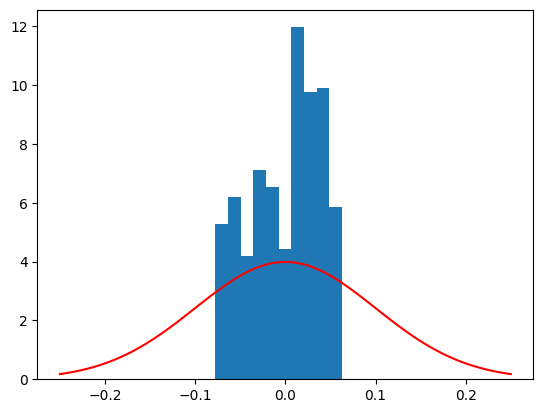

In [ ]:
ys = f(dom)

residual = ys - y_hats

z = np.linspace(-0.25, .25, 100)

plt.hist(residual, density=True)
plt.plot(z, stats.norm.pdf(z, 0, 0.1), color="red")
plt.show()